In [1]:

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as sig

os.chdir(os.path.dirname(os.getcwd()))

import spatial_metrics.helper_functions as hf
import spatial_metrics.detect_peaks as dp

import spatial_metrics.cell_model_base as cs_model
import spatial_metrics.spatial_metrics_base as pl



In [2]:

srate = 30. # points/frames per second
total_Time = 1000 # in seconds
_lambda = 10 # how much your neuron should spike
environment_edges = [[0,100],[0,100]] # in cm [[x1,x2],[y1,y2]]

x_coordinates,y_coordinates,speed,timevector = cs_model.generate_random_walk(input_srate = srate,input_total_Time = total_Time,heading_srate = 10., speed_srate = 5., rho1  = 1,sigma = 0.02,mu_e  = 0.,smooth_coeff = 0.5,environment_edges = environment_edges)
total_points = timevector.shape[0]


timestamps = cs_model.generate_arrivals(_lambda,total_Time)
I_timestamps = (timestamps*srate).astype(int)

# place cell with one field: x_center and y_center is the location of the place field in the environment; s is the field extension
modulated_timestamps = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 35,y_center = 25, s = 10)

# grid cell with several fields
# modulated_timestamps1 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 50,y_center = 50, s = 5)
# modulated_timestamps2 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 10,y_center = 10, s = 5)
# modulated_timestamps3 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 10,y_center = 90, s = 5)
# modulated_timestamps4 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 90,y_center = 90, s = 5)
# modulated_timestamps5 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 90,y_center = 10, s = 5)
# modulated_timestamps = np.unique(np.concatenate([modulated_timestamps1,modulated_timestamps2,modulated_timestamps3,modulated_timestamps4,modulated_timestamps5]))

# if you want to control for the amount of spikes, set a fixed value for spikes
# num_of_spikes = 1000
# modulated_timestamps = np.sort(np.random.choice(modulated_timestamps,num_of_spikes,replace=False))

calcium_imag,timevector = cs_model.generate_calcium_signal(modulated_timestamps,total_points,srate,noise_level = 0.01, b = 5.)
calcium_events = modulated_timestamps.shape[0]
I_peaks = dp.detect_peaks(calcium_imag,mpd=0.5*srate,mph=1.*np.nanstd(calcium_imag))



In [3]:
# video sampling rate (it can be an approximation of the coordinates timestamps for cameras with varying frame rates)
srate = 1/np.nanmean(np.diff(timevector))

input_dict = dict()
input_dict['saving_string'] = 'SpatialMetrics.Continuous'
input_dict['animal_id'] = 'NeuronModel'
input_dict['dataset'] = 'Simulation'
input_dict['day'] = 1
input_dict['neuron'] = 1
input_dict['trial'] = None
input_dict['mean_video_srate'] = srate
input_dict['mintimespent'] = 0
input_dict['minvisits'] = 0
input_dict['speed_threshold'] = 0 
input_dict['x_bin_size'] = 1 # y bin size in cm
input_dict['y_bin_size'] = 1 # y bin size in cm
input_dict['environment_edges'] = environment_edges # in cm
input_dict['shift_time'] = 10
input_dict['num_cores'] = 20
input_dict['num_surrogates'] = 100
input_dict['saving_path'] = None
input_dict['saving'] = False
input_dict['smoothing_size'] = 4
input_dict['nbins_cal'] = 10

place_cell = pl.PlaceCell(**input_dict)

place_cell_output = place_cell.main(calcium_imag,timevector,x_coordinates,y_coordinates)


/projects/ag-korotkova/v1/korotkova_group/matlab_scripts/Rob/CalciumImaging/scripts/spatial_project/spatial_metrics/spatial_metrics_base.py:311: RuntimeWarning: Mean of empty slice
  calcium_mean_occupancy[yy,xx] = np.nanmean(calcium_imag[np.logical_and(check_x_ocuppancy,check_y_ocuppancy)])
/projects/ag-korotkova/v1/korotkova_group/matlab_scripts/Rob/CalciumImaging/scripts/spatial_project/spatial_metrics/spatial_metrics_base.py:518: RuntimeWarning: invalid value encountered in log
  observed_distr = -np.nansum((mean_calcium_activity/np.nansum(mean_calcium_activity))*np.log((mean_calcium_activity/np.nansum(mean_calcium_activity))))
/projects/ag-korotkova/v1/korotkova_group/matlab_scripts/Rob/CalciumImaging/scripts/spatial_project/spatial_metrics/spatial_metrics_base.py:542: RuntimeWarning: invalid value encountered in log2
  mutual_info_skaggs = np.nansum((bin_probability*(mean_calcium_activity/overall_mean_amplitude))*np.log2(mean_calcium_activity/overall_mean_amplitude))


SpatialMetrics.Continuous.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved


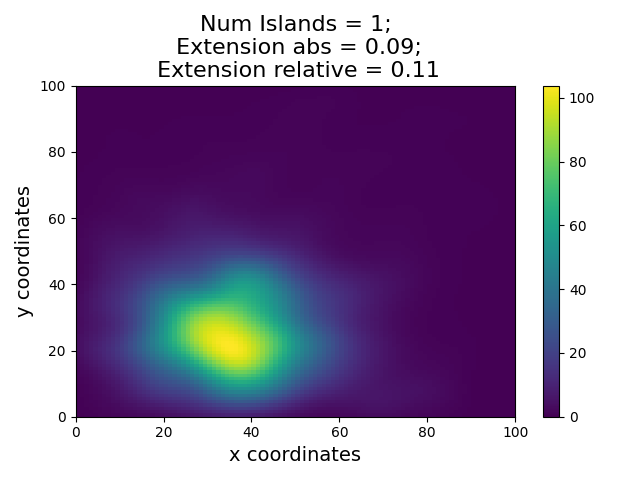

In [4]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'])
plt.colorbar()
plt.title('Num Islands = {0};\n Extension abs = {1:0.2f};\n Extension relative = {2:0.2f}'.format(place_cell_output['num_of_islands'],place_cell_output['place_cell_extension_absolute'],place_cell_output['place_cell_extension_relative']) ,fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


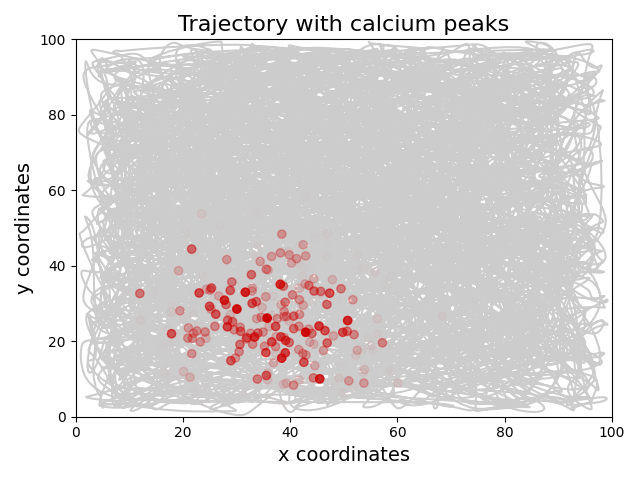

In [5]:

x_peaks_location = place_cell_output['x_peaks_location']
y_peaks_location = place_cell_output['y_peaks_location']

events_amplitude = place_cell_output['events_amplitude']
events_amplitude_norm = (events_amplitude-np.nanmin(events_amplitude))/(np.nanmax(events_amplitude)-np.nanmin(events_amplitude))
if np.all(np.isnan(events_amplitude_norm)):
    events_amplitude_norm = np.ones(events_amplitude_norm.shape[0])

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k',alpha=0.2)
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red')
plt.title('Trajectory with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


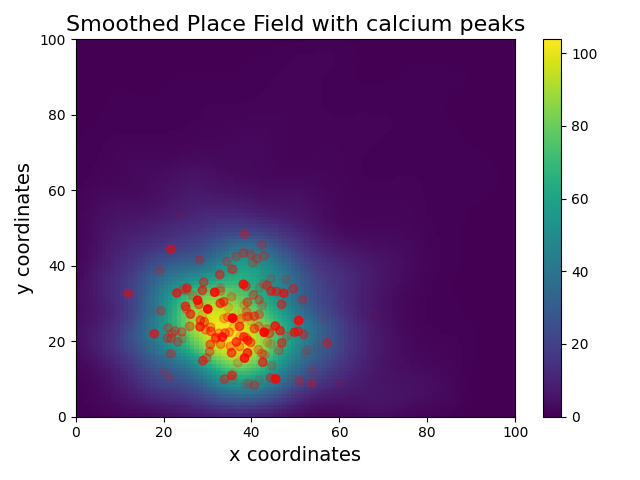

In [6]:
x_peaks_location = place_cell_output['x_peaks_location']
y_peaks_location = place_cell_output['y_peaks_location']

events_amplitude = place_cell_output['events_amplitude']
events_amplitude_norm = (events_amplitude-np.nanmin(events_amplitude))/(np.nanmax(events_amplitude)-np.nanmin(events_amplitude))
if np.all(np.isnan(events_amplitude_norm)):
    events_amplitude_norm = np.ones(events_amplitude_norm.shape[0])
    
plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'])
plt.colorbar()
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red')
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


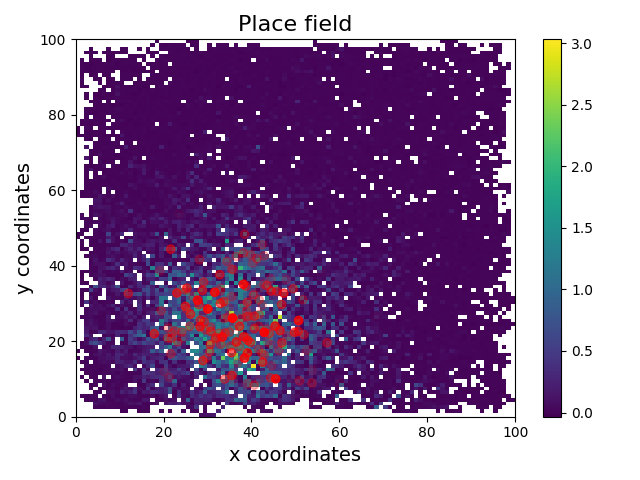

In [7]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field'])
plt.colorbar()
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red')
plt.title('Place field',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


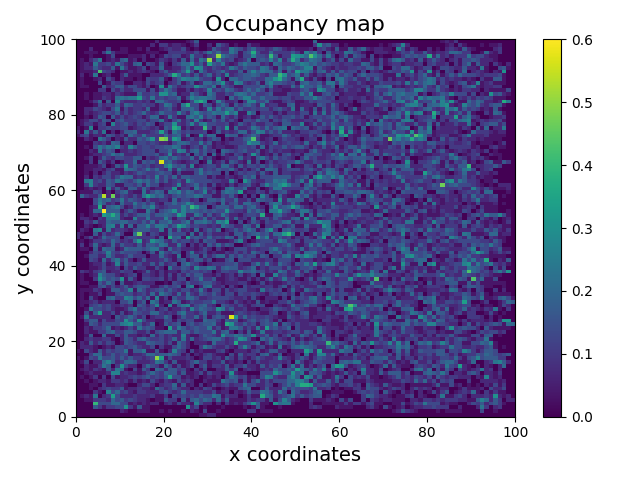

In [8]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['ocuppancy_map'])
plt.colorbar()
plt.title('Occupancy map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


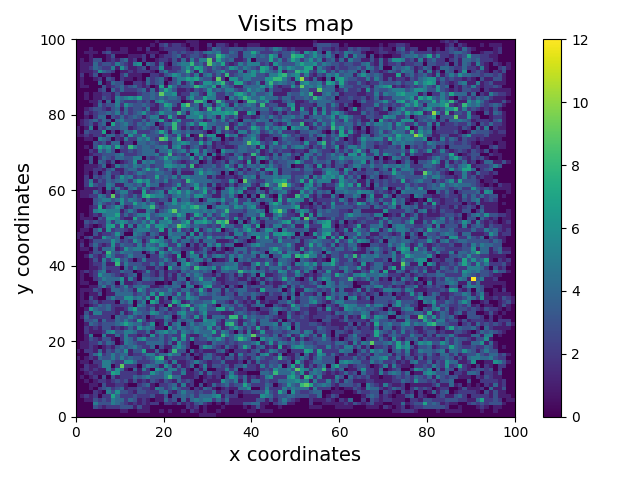

In [9]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['visits_map'])
plt.colorbar()
plt.title('Visits map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


In [10]:
place_cell_output.keys()

dict_keys(['signal_map', 'place_field', 'place_field_smoothed', 'ocuppancy_map', 'visits_map', 'x_grid', 'y_grid', 'x_center_bins', 'y_center_bins', 'numb_events', 'x_peaks_location', 'y_peaks_location', 'events_amplitude', 'mutual_info_original', 'mutual_info_shuffled', 'mutual_info_zscored', 'mutual_info_centered', 'num_of_islands', 'place_cell_extension_absolute', 'place_cell_extension_relative', 'kullback_leibler_mod_index', 'kullback_leibler_mod_index_shuffled', 'kullback_leibler_mod_index_zscored', 'kullback_leibler_mod_index_centered', 'mutual_info_NN_original', 'mutual_info_NN_shuffled', 'mutual_info_NN_zscored', 'mutual_info_NN_centered', 'mutual_info_skaggs_original', 'mutual_info_skaggs_shuffled', 'mutual_info_skaggs_zscored', 'mutual_info_skaggs_centered', 'input_parameters'])

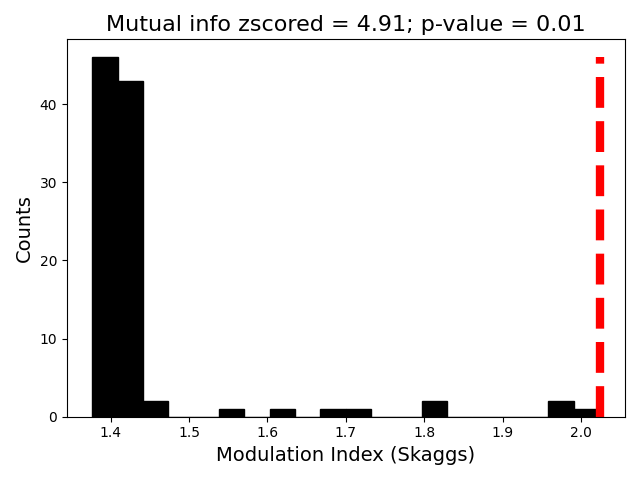

In [11]:
# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_skaggs_shuffled'] >= place_cell_output['mutual_info_skaggs_original'])/place_cell_output['mutual_info_skaggs_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_skaggs_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output['mutual_info_skaggs_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_skaggs_original'],place_cell_output['mutual_info_skaggs_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_skaggs_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (Skaggs)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


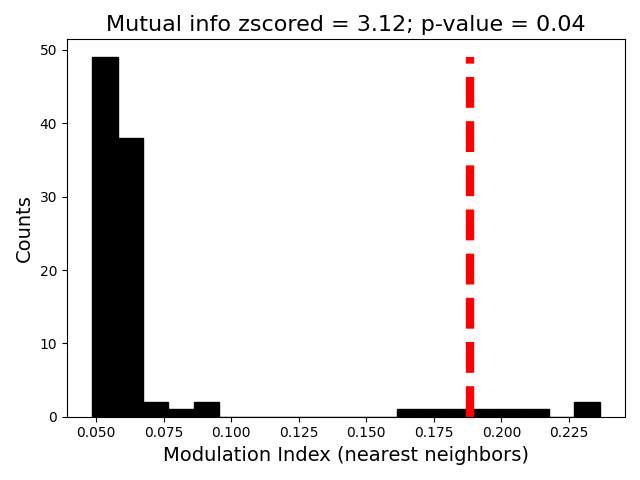

In [12]:
# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_NN_shuffled'] >= place_cell_output['mutual_info_NN_original'])/place_cell_output['mutual_info_NN_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_NN_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output['mutual_info_NN_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_NN_original'],place_cell_output['mutual_info_NN_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_NN_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (nearest neighbors)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


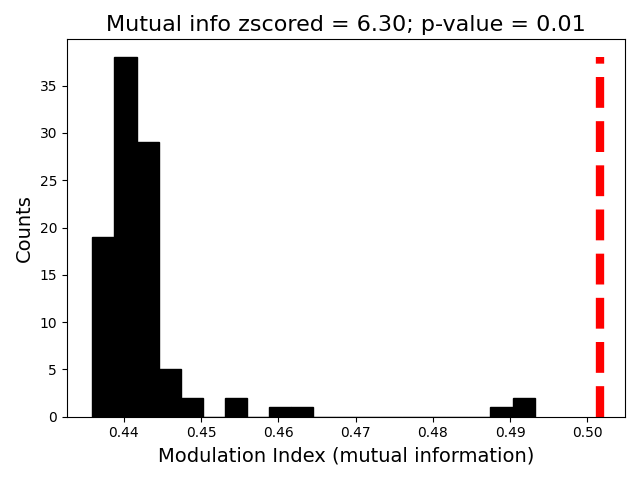

In [13]:
# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_shuffled'] >= place_cell_output['mutual_info_original'])/place_cell_output['mutual_info_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output['mutual_info_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_original'],place_cell_output['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (mutual information)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


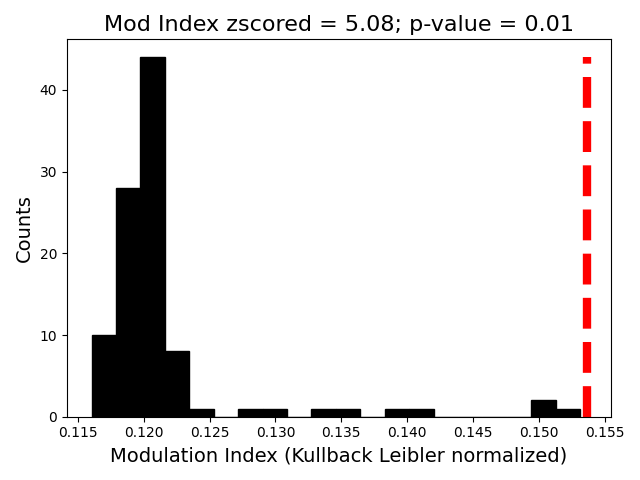

In [14]:
# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output['kullback_leibler_mod_index_shuffled'] >= place_cell_output['kullback_leibler_mod_index'])/place_cell_output['kullback_leibler_mod_index_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['kullback_leibler_mod_index_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output['kullback_leibler_mod_index_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['kullback_leibler_mod_index'],place_cell_output['kullback_leibler_mod_index']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mod Index zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['kullback_leibler_mod_index_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (Kullback Leibler normalized)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()



In [15]:
# Surrogate procedure demonstration - take the signal above, shuffle it and check if it is significant (it shouldn't)

# https://www.sciencedirect.com/science/article/pii/S0370157318301340

# video sampling rate (it can be an approximation of the coordinates timestamps for cameras with varying frame rates)
srate = 1/np.nanmean(np.diff(timevector))

input_dict = dict()
input_dict['saving_string'] = 'SpatialMetrics.Continuous'
input_dict['animal_id'] = 'NeuronModel'
input_dict['dataset'] = 'Simulation'
input_dict['day'] = 1
input_dict['neuron'] = 1
input_dict['trial'] = None
input_dict['mean_video_srate'] = srate
input_dict['mintimespent'] = 0
input_dict['minvisits'] = 0
input_dict['speed_threshold'] = 0 
input_dict['x_bin_size'] = 1 # y bin size in cm
input_dict['y_bin_size'] = 1 # y bin size in cm
input_dict['environment_edges'] = environment_edges # in cm
input_dict['shift_time'] = 10
input_dict['num_cores'] = 20
input_dict['num_surrogates'] = 100
input_dict['saving_path'] = None
input_dict['saving'] = False
input_dict['smoothing_size'] = 4
input_dict['nbins_cal'] = 10

place_cell_shuff = pl.PlaceCell(**input_dict)

calcium_imag_shuffled = place_cell_shuff.get_surrogate(calcium_imag,shift_time=200,mean_video_srate = srate)

place_cell_output_shuff = place_cell_shuff.main(calcium_imag_shuffled,timevector,x_coordinates,y_coordinates)


/projects/ag-korotkova/v1/korotkova_group/matlab_scripts/Rob/CalciumImaging/scripts/spatial_project/spatial_metrics/spatial_metrics_base.py:311: RuntimeWarning: Mean of empty slice
  calcium_mean_occupancy[yy,xx] = np.nanmean(calcium_imag[np.logical_and(check_x_ocuppancy,check_y_ocuppancy)])
/projects/ag-korotkova/v1/korotkova_group/matlab_scripts/Rob/CalciumImaging/scripts/spatial_project/spatial_metrics/spatial_metrics_base.py:518: RuntimeWarning: invalid value encountered in log
  observed_distr = -np.nansum((mean_calcium_activity/np.nansum(mean_calcium_activity))*np.log((mean_calcium_activity/np.nansum(mean_calcium_activity))))
/projects/ag-korotkova/v1/korotkova_group/matlab_scripts/Rob/CalciumImaging/scripts/spatial_project/spatial_metrics/spatial_metrics_base.py:542: RuntimeWarning: invalid value encountered in log2
  mutual_info_skaggs = np.nansum((bin_probability*(mean_calcium_activity/overall_mean_amplitude))*np.log2(mean_calcium_activity/overall_mean_amplitude))


SpatialMetrics.Continuous.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved


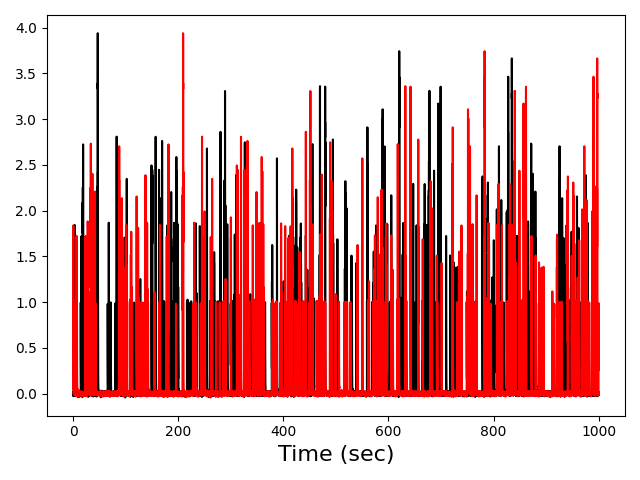

In [16]:

plt.figure()
plt.plot(timevector,calcium_imag,'k')
plt.plot(timevector,calcium_imag_shuffled,'r')
plt.xlabel('Time (sec)', fontsize=16)
plt.tight_layout()
plt.show()

# os.chdir(path + '/figures/')
# plt.savefig('Surrogate_Trace_Example{0}.svg'.format(surr))


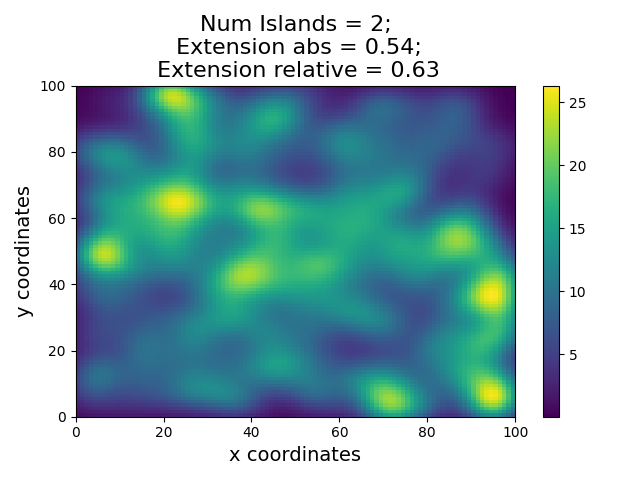

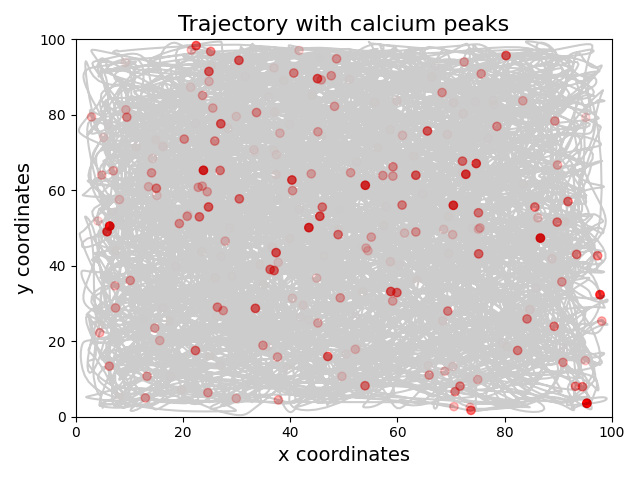

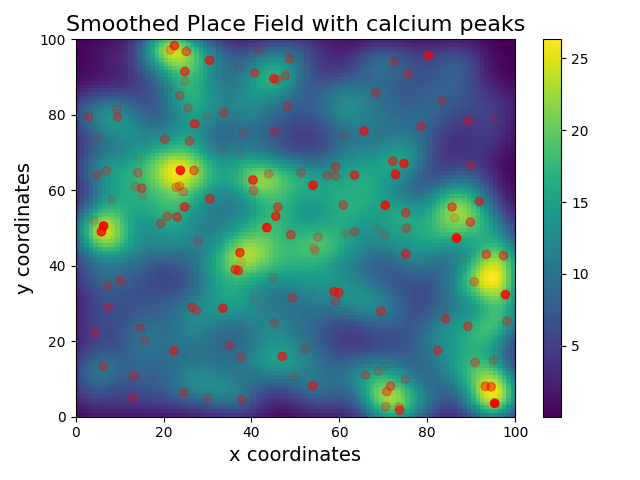

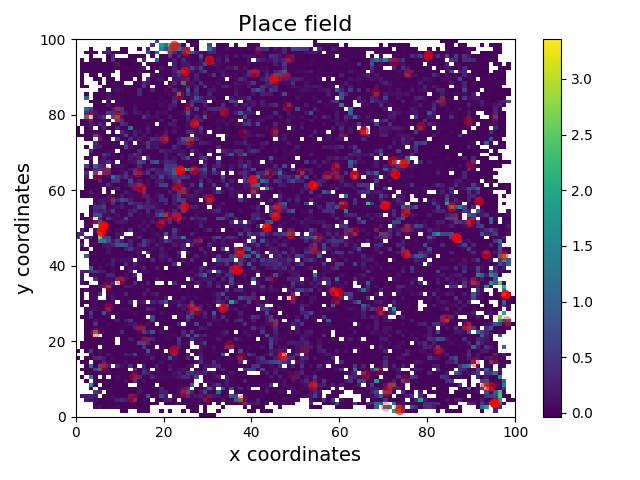

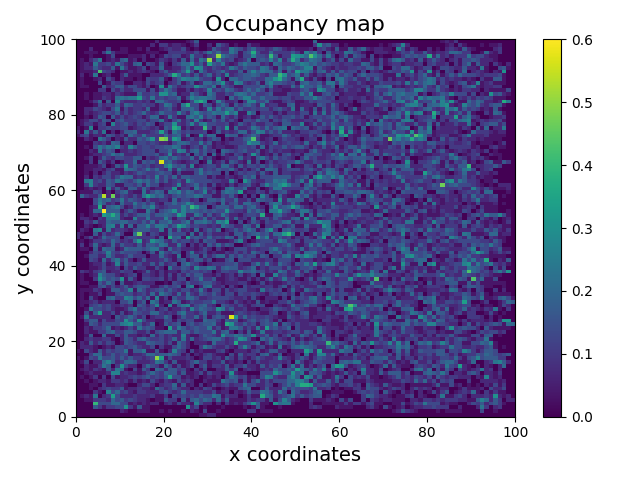

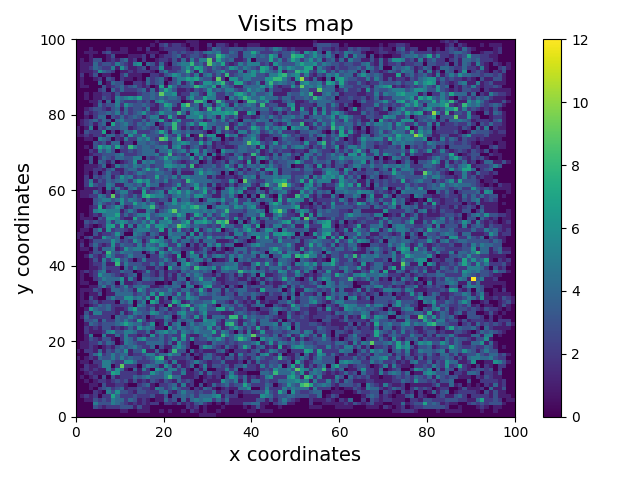

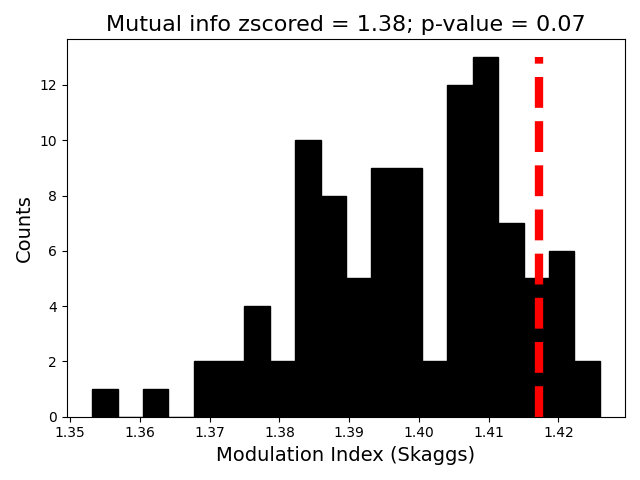

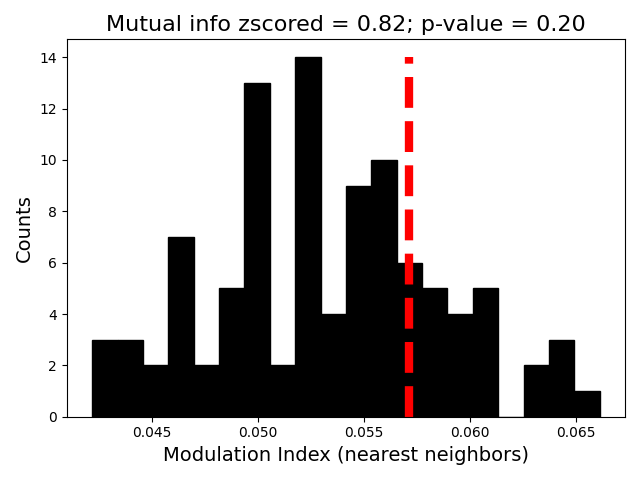

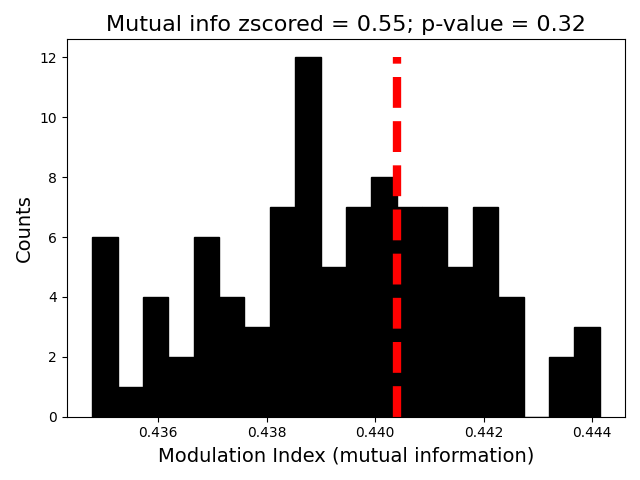

/tmp/ipykernel_16603/3280396228.py:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


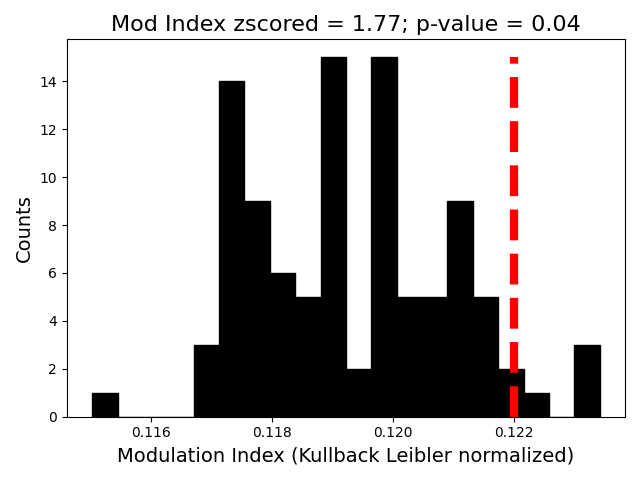

In [17]:

plt.figure()
plt.pcolormesh(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['place_field_smoothed'])
plt.colorbar()
plt.title('Num Islands = {0};\n Extension abs = {1:0.2f};\n Extension relative = {2:0.2f}'.format(place_cell_output_shuff['num_of_islands'],place_cell_output_shuff['place_cell_extension_absolute'],place_cell_output_shuff['place_cell_extension_relative']) ,fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



x_peaks_location = place_cell_output_shuff['x_peaks_location']
y_peaks_location = place_cell_output_shuff['y_peaks_location']

events_amplitude = place_cell_output_shuff['events_amplitude']
events_amplitude_norm = (events_amplitude-np.nanmin(events_amplitude))/(np.nanmax(events_amplitude)-np.nanmin(events_amplitude))
if np.all(np.isnan(events_amplitude_norm)):
    events_amplitude_norm = np.ones(events_amplitude_norm.shape[0])

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k',alpha=0.2)
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red')
plt.title('Trajectory with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


x_peaks_location = place_cell_output_shuff['x_peaks_location']
y_peaks_location = place_cell_output_shuff['y_peaks_location']

events_amplitude = place_cell_output_shuff['events_amplitude']
events_amplitude_norm = (events_amplitude-np.nanmin(events_amplitude))/(np.nanmax(events_amplitude)-np.nanmin(events_amplitude))
if np.all(np.isnan(events_amplitude_norm)):
    events_amplitude_norm = np.ones(events_amplitude_norm.shape[0])
    
plt.figure()
plt.pcolormesh(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['place_field_smoothed'])
plt.colorbar()
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red')
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()




plt.figure()
plt.pcolormesh(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['place_field'])
plt.colorbar()
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red')
plt.title('Place field',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()




plt.figure()
plt.pcolormesh(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['ocuppancy_map'])
plt.colorbar()
plt.title('Occupancy map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()





plt.figure()
plt.pcolormesh(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['visits_map'])
plt.colorbar()
plt.title('Visits map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()

# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output_shuff['mutual_info_skaggs_shuffled'] >= place_cell_output_shuff['mutual_info_skaggs_original'])/place_cell_output_shuff['mutual_info_skaggs_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output_shuff['mutual_info_skaggs_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output_shuff['mutual_info_skaggs_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output_shuff['mutual_info_skaggs_original'],place_cell_output_shuff['mutual_info_skaggs_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output_shuff['mutual_info_skaggs_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (Skaggs)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output_shuff['mutual_info_NN_shuffled'] >= place_cell_output_shuff['mutual_info_NN_original'])/place_cell_output_shuff['mutual_info_NN_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output_shuff['mutual_info_NN_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output_shuff['mutual_info_NN_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output_shuff['mutual_info_NN_original'],place_cell_output_shuff['mutual_info_NN_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output_shuff['mutual_info_NN_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (nearest neighbors)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output_shuff['mutual_info_shuffled'] >= place_cell_output_shuff['mutual_info_original'])/place_cell_output_shuff['mutual_info_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output_shuff['mutual_info_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output_shuff['mutual_info_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output_shuff['mutual_info_original'],place_cell_output_shuff['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output_shuff['mutual_info_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (mutual information)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output_shuff['kullback_leibler_mod_index_shuffled'] >= place_cell_output_shuff['kullback_leibler_mod_index'])/place_cell_output_shuff['kullback_leibler_mod_index_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output_shuff['kullback_leibler_mod_index_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output_shuff['kullback_leibler_mod_index_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output_shuff['kullback_leibler_mod_index'],place_cell_output_shuff['kullback_leibler_mod_index']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mod Index zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output_shuff['kullback_leibler_mod_index_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (Kullback Leibler normalized)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()



